# 1. Import Module & Data

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import figure
import matplotlib.pyplot as plt
import math
import os
import time
import random
import gc
from sklearn.preprocessing import StandardScaler
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

In [3]:
data_folder = '../data/'
os.makedirs(data_folder, exist_ok=True)

df = pd.read_csv(data_folder + 'traffic.csv', header=None)
df = df[1:].astype('float').T

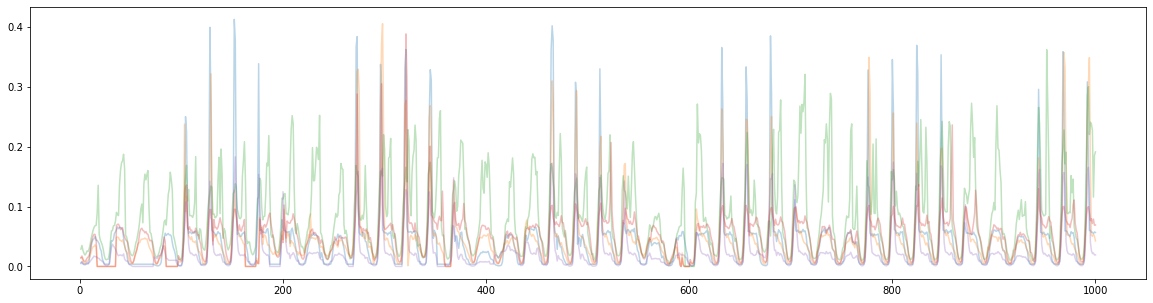

In [4]:
plt.figure(figsize=(20,5))
plt.plot(df.iloc[:5, :1000].T, alpha=.3)
plt.show()

In [5]:
from torch import nn
from torch.utils.data import Dataset, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import torch

import os
import statistics
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import json
import matplotlib.pyplot as plt

SEED = 10
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

### Special DataLoader for Traffic Data ###

In [6]:
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch

import numpy as np
def normal_std(x):
    return x.std() * np.sqrt((len(x) - 1.) / (len(x)))

class DataLoaderH(object):
    # train and valid is the ratio of training set and validation set. test = 1 - train - valid
    def __init__(self, file_name, train, valid, horizon, window, pred_step, normalize=2):
        """
        1.Get Data
        2. Normalize 
        3. Split
        """
        self.P = window
        self.h = horizon
        self.pred_step = pred_step
        
        fin = open(file_name)
        self.rawdat = np.loadtxt(fin, delimiter=',')
        self.dat = np.zeros(self.rawdat.shape)

        self.n, self.m = self.dat.shape
        self.normalize = 2
        self.scale = np.ones(self.m)
        self.bias =  np.zeros(self.m)
        self._normalized(normalize)
        self._split(int(train * self.n), int((train + valid) * self.n), self.n)

        self.scale = torch.from_numpy(self.scale).float()
        self.bias = torch.from_numpy(self.bias).float()
        tmp = self.test[1] * self.scale.expand(self.test[1].size(0), self.h, self.m)

        self.scale = self.scale.cuda()
        self.scale = Variable(self.scale)
        self.bias = self.bias.cuda()
        self.bias = Variable(self.bias)

        tmp = tmp[:, -1, :].squeeze()
        self.rse = normal_std(tmp)
        self.rae = torch.mean(torch.abs(tmp - torch.mean(tmp)))

    def _normalized(self, normalize):
        """
        Normalize Data
        0. No Normalization
        1. MinMaxScaler - by one scaler
        2. MinMaxScaler - by each sensor
        3. StandardScaler - by each sensor
        """
        if (normalize == 0):
            self.dat = self.rawdat

        if (normalize == 1):
            # normalized by the maximum value of entire matrix.
            self.dat = self.rawdat / np.max(self.rawdat)
        
        if (normalize == 2):
            # normlized by the maximum value of each row (sensor).
            for i in range(self.m):
                self.scale[i] = np.max(np.abs(self.rawdat[:, i]))
                self.dat[:, i] = self.rawdat[:, i] / np.max(np.abs(self.rawdat[:, i]))

        if (normalize == 3):
            # normlized by the mean/std value of each row (sensor).
            for i in range(self.m):
                self.scale[i] = np.std(self.rawdat[:, i]) #std
                self.bias[i] = np.mean(self.rawdat[:, i])
                self.dat[:, i] = (self.rawdat[:, i] - self.bias[i]) / self.scale[i]


    def _split(self, train, valid, test):
        """
        Train-Valid-Test Split
        1. Make as Dataset
        2. Make as Loader
        """
        train_set = range(self.P + self.pred_step, train)
        valid_set = range(train, valid)
        test_set = range(valid, self.n)
        self.train = self._batchify(train_set, self.h)
        self.valid = self._batchify(valid_set, self.h)
        self.test = self._batchify(test_set, self.h)

    def _batchify(self, idx_set, horizon):
        n = len(idx_set)
        X = torch.zeros((n, self.P, self.m))
        Y = torch.zeros((n, self.h, self.m))
        for i in range(n):
            end = idx_set[i] - self.pred_step + 1
            start = end - self.P
            X[i, :, :] = torch.from_numpy(self.dat[start:end, :])
            Y[i, :, :] = torch.from_numpy(self.dat[[end+self.pred_step-1], :])
        return [X, Y]

    def get_batches(self, inputs, targets, batch_size, shuffle=True):
        """
        get Batch
        """
        length = len(inputs)
        if shuffle:
            index = torch.randperm(length)
        else:
            index = torch.LongTensor(range(length))
        start_idx = 0
        while (start_idx < length):
            end_idx = min(length, start_idx + batch_size)
            excerpt = index[start_idx:end_idx]
            X = inputs[excerpt]
            Y = targets[excerpt]
            X = X.cuda()
            Y = Y.cuda()
            yield Variable(X), Variable(Y)
            start_idx += batch_size

In [7]:
batch_size = 64
num_workers = 4
pin_memory = True
device = 'cuda'
num_epoch = 200
lr = 1e-4

In [8]:
train_ratio = 0.6
valid_ratio = 0.2
window = 168
horizon = 1
pred_step = 24
normalize = 2

loader = DataLoaderH(data_folder+'traffic.txt', train_ratio, valid_ratio, horizon, window, pred_step, normalize)

# 2. CNN Model (similar architecture w DynamicRouting CapsNet)

In [9]:
result_folder = '../check/cnn/prediction/'
os.makedirs(result_folder, exist_ok=True)

attack_result_folder = '../check/cnn/prediction_attack/'
os.makedirs(attack_result_folder, exist_ok=True)

In [10]:
class CNN(nn.Module):
    def __init__(self, in_features, out_features, pool_size, hidden_dim, capsule_num):
        super().__init__()
        self.output = out_features
        self.pool_size = pool_size
        
        self.hidden_dim = hidden_dim
        self.capsule_num = capsule_num
        
        self.conv1 = nn.Conv2d(in_features, self.hidden_dim, kernel_size=(9, 1), stride=1)
        #self.pool1 = nn.MaxPool2d((1, self.pool_size),1)
        
        self.conv2 = nn.Conv2d(self.hidden_dim, self.hidden_dim, kernel_size=(9, 1), stride=(2,1))
        #self.pool2 = nn.MaxPool2d((1, self.pool_size),1)
        
        self.conv3 = nn.Conv2d(self.hidden_dim, 7*capsule_num*2, kernel_size=(1,1), stride=1)
        self.pool3 = nn.AdaptiveMaxPool2d(1)
       
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(7*capsule_num*2, 512)
        self.fc2 = nn.Linear(512, 1024)
        self.out = nn.Linear(1024, out_features)

    def forward(self, x):
        x = F.relu(self.conv1(x.transpose(1,2).unsqueeze(-1)))# 2. CNN Model (similar architecture w DynamicRouting CapsNet)
        x = F.relu(self.conv2(x))
        x = F.relu(self.pool3(self.conv3(x)))
        
        x = self.flatten(x).unsqueeze(1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = (self.out(x))
        
        return x

In [11]:
model = CNN(in_features= 862,
            out_features=862, #classifcation = 5
            pool_size=3, hidden_dim = 256, capsule_num=8).to(device) 

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, 'min')
criterion = nn.MSELoss()

In [12]:
model

CNN(
  (conv1): Conv2d(862, 256, kernel_size=(9, 1), stride=(1, 1))
  (conv2): Conv2d(256, 256, kernel_size=(9, 1), stride=(2, 1))
  (conv3): Conv2d(256, 112, kernel_size=(1, 1), stride=(1, 1))
  (pool3): AdaptiveMaxPool2d(output_size=1)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=112, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1024, bias=True)
  (out): Linear(in_features=1024, out_features=862, bias=True)
)

# Model Training & Evaluation #

In [13]:
train_loss_list = []
valid_loss_list = []

data = loader
X_train = data.train[0]
Y_train = data.train[1]

X_valid = data.valid[0]
Y_valid = data.valid[1]
    
for epoch in range(0, num_epoch+1):
    model = model.train()

    train_loss = []
    for (x, y) in tqdm(data.get_batches(X_train, Y_train, 64, False), leave=False):
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        outputs = model(x).squeeze()
        y = y.squeeze()

        scale = data.scale.expand(outputs.size(0), horizon, data.m).squeeze()
        bias = data.bias.expand(outputs.size(0), horizon, data.m).squeeze()

        loss = torch.sqrt(criterion(outputs*scale+bias, y*scale+bias))
        
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())

    train_loss = np.mean(train_loss)
    
    model = model.eval()
    predictions = []
    answers = []
    valid_loss = []
    with torch.no_grad():
        for (x, y) in tqdm(data.get_batches(X_valid, Y_valid, 64, False), leave=False):
            x = x.to(device)
            y = y.to(device)
            answers.extend(y.detach().cpu().numpy())

            outputs = model(x).squeeze()
            y = y.squeeze()

            scale = data.scale.expand(outputs.size(0), horizon, data.m).squeeze()
            bias = data.bias.expand(outputs.size(0), horizon, data.m).squeeze()

            loss = torch.sqrt(criterion(outputs*scale+bias, y*scale+bias))
        
            predictions.extend(outputs.squeeze().detach().cpu().numpy())
            valid_loss.append(loss.item())    

    valid_loss = np.mean(valid_loss)
    
    print("epoch: {}/{} | trn_loss: {:.4f} | val_loss: {:.4f}".format(
                epoch, num_epoch, train_loss, valid_loss
            ))
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    
    """
    if epoch % 20 ==0 :       
        torch.save({
            'epoch': epoch,
            'loss': valid_loss_list[-1],
            'model_state_dict' : model.state_dict(),
            'optimizer_state_dict' : optimizer.state_dict(),
            'criterion' : criterion
        }, result_folder + f'cnn-swcapsule-pred-traffic-best.pt')s
    """
    
    if (epoch==0) or (epoch>0 and (min(valid_loss_list[:-1])>valid_loss_list[-1])):
        torch.save({
            'epoch': epoch,
            'loss': valid_loss_list[-1],
            'model_state_dict' : model.state_dict(),
            'optimizer_state_dict' : optimizer.state_dict(),
            'criterion' : criterion
        }, result_folder + f'cnn-swcapsule-pred-traffic-best.pt')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 0/200 | trn_loss: 0.0504 | val_loss: 0.0507


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 1/200 | trn_loss: 0.0485 | val_loss: 0.0507


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 2/200 | trn_loss: 0.0484 | val_loss: 0.0508


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 3/200 | trn_loss: 0.0484 | val_loss: 0.0508


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 4/200 | trn_loss: 0.0484 | val_loss: 0.0508


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 5/200 | trn_loss: 0.0483 | val_loss: 0.0507


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 6/200 | trn_loss: 0.0480 | val_loss: 0.0507


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 7/200 | trn_loss: 0.0476 | val_loss: 0.0510


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 8/200 | trn_loss: 0.0473 | val_loss: 0.0508


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 9/200 | trn_loss: 0.0471 | val_loss: 0.0495


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 10/200 | trn_loss: 0.0468 | val_loss: 0.0489


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 11/200 | trn_loss: 0.0464 | val_loss: 0.0485


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 12/200 | trn_loss: 0.0461 | val_loss: 0.0483


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 13/200 | trn_loss: 0.0456 | val_loss: 0.0477


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 14/200 | trn_loss: 0.0450 | val_loss: 0.0469


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 15/200 | trn_loss: 0.0443 | val_loss: 0.0468


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 16/200 | trn_loss: 0.0439 | val_loss: 0.0474


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 17/200 | trn_loss: 0.0437 | val_loss: 0.0457


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 18/200 | trn_loss: 0.0434 | val_loss: 0.0456


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 19/200 | trn_loss: 0.0434 | val_loss: 0.0455


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 20/200 | trn_loss: 0.0438 | val_loss: 0.0455


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 21/200 | trn_loss: 0.0447 | val_loss: 0.0471


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 22/200 | trn_loss: 0.0441 | val_loss: 0.0484


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 23/200 | trn_loss: 0.0433 | val_loss: 0.0470


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 24/200 | trn_loss: 0.0427 | val_loss: 0.0462


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 25/200 | trn_loss: 0.0422 | val_loss: 0.0463


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 26/200 | trn_loss: 0.0417 | val_loss: 0.0462


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 27/200 | trn_loss: 0.0414 | val_loss: 0.0464


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 28/200 | trn_loss: 0.0413 | val_loss: 0.0463


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 29/200 | trn_loss: 0.0410 | val_loss: 0.0460


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 30/200 | trn_loss: 0.0409 | val_loss: 0.0479


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 31/200 | trn_loss: 0.0409 | val_loss: 0.0464


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 32/200 | trn_loss: 0.0409 | val_loss: 0.0483


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 33/200 | trn_loss: 0.0407 | val_loss: 0.0444


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 34/200 | trn_loss: 0.0410 | val_loss: 0.0435


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 35/200 | trn_loss: 0.0408 | val_loss: 0.0443


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 36/200 | trn_loss: 0.0402 | val_loss: 0.0437


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 37/200 | trn_loss: 0.0403 | val_loss: 0.0448


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 38/200 | trn_loss: 0.0402 | val_loss: 0.0451


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 39/200 | trn_loss: 0.0401 | val_loss: 0.0455


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 40/200 | trn_loss: 0.0398 | val_loss: 0.0447


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 41/200 | trn_loss: 0.0398 | val_loss: 0.0435


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 42/200 | trn_loss: 0.0400 | val_loss: 0.0461


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 43/200 | trn_loss: 0.0403 | val_loss: 0.0441


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 44/200 | trn_loss: 0.0403 | val_loss: 0.0449


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 45/200 | trn_loss: 0.0404 | val_loss: 0.0462


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 46/200 | trn_loss: 0.0405 | val_loss: 0.0464


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 47/200 | trn_loss: 0.0404 | val_loss: 0.0462


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 48/200 | trn_loss: 0.0402 | val_loss: 0.0475


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 49/200 | trn_loss: 0.0400 | val_loss: 0.0452


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 50/200 | trn_loss: 0.0397 | val_loss: 0.0453


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 51/200 | trn_loss: 0.0395 | val_loss: 0.0443


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 52/200 | trn_loss: 0.0392 | val_loss: 0.0439


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 53/200 | trn_loss: 0.0391 | val_loss: 0.0462


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 54/200 | trn_loss: 0.0391 | val_loss: 0.0463


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 55/200 | trn_loss: 0.0396 | val_loss: 0.0505


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 56/200 | trn_loss: 0.0393 | val_loss: 0.0482


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 57/200 | trn_loss: 0.0390 | val_loss: 0.0484


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 58/200 | trn_loss: 0.0386 | val_loss: 0.0532


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 59/200 | trn_loss: 0.0389 | val_loss: 0.0531


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 60/200 | trn_loss: 0.0389 | val_loss: 0.0518


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 61/200 | trn_loss: 0.0387 | val_loss: 0.0517


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 62/200 | trn_loss: 0.0385 | val_loss: 0.0529


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 63/200 | trn_loss: 0.0386 | val_loss: 0.0538


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 64/200 | trn_loss: 0.0388 | val_loss: 0.0544


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 65/200 | trn_loss: 0.0388 | val_loss: 0.0483


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 66/200 | trn_loss: 0.0392 | val_loss: 0.0446


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 67/200 | trn_loss: 0.0393 | val_loss: 0.0430


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 68/200 | trn_loss: 0.0390 | val_loss: 0.0438


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 69/200 | trn_loss: 0.0386 | val_loss: 0.0450


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 70/200 | trn_loss: 0.0384 | val_loss: 0.0438


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 71/200 | trn_loss: 0.0380 | val_loss: 0.0446


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 72/200 | trn_loss: 0.0382 | val_loss: 0.0441


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 73/200 | trn_loss: 0.0385 | val_loss: 0.0446


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 74/200 | trn_loss: 0.0385 | val_loss: 0.0445


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 75/200 | trn_loss: 0.0385 | val_loss: 0.0472


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 76/200 | trn_loss: 0.0379 | val_loss: 0.0431


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 77/200 | trn_loss: 0.0377 | val_loss: 0.0440


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 78/200 | trn_loss: 0.0374 | val_loss: 0.0434


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 79/200 | trn_loss: 0.0375 | val_loss: 0.0435


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 80/200 | trn_loss: 0.0374 | val_loss: 0.0440


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 81/200 | trn_loss: 0.0371 | val_loss: 0.0435


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 82/200 | trn_loss: 0.0374 | val_loss: 0.0427


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 83/200 | trn_loss: 0.0375 | val_loss: 0.0445


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 84/200 | trn_loss: 0.0374 | val_loss: 0.0430


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 85/200 | trn_loss: 0.0372 | val_loss: 0.0443


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 86/200 | trn_loss: 0.0372 | val_loss: 0.0438


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 87/200 | trn_loss: 0.0371 | val_loss: 0.0440


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 88/200 | trn_loss: 0.0369 | val_loss: 0.0478


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 89/200 | trn_loss: 0.0377 | val_loss: 0.0482


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 90/200 | trn_loss: 0.0368 | val_loss: 0.0459


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 91/200 | trn_loss: 0.0370 | val_loss: 0.0480


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 92/200 | trn_loss: 0.0379 | val_loss: 0.0498


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 93/200 | trn_loss: 0.0376 | val_loss: 0.0480


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 94/200 | trn_loss: 0.0370 | val_loss: 0.0466


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 95/200 | trn_loss: 0.0369 | val_loss: 0.0474


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 96/200 | trn_loss: 0.0374 | val_loss: 0.0441


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 97/200 | trn_loss: 0.0374 | val_loss: 0.0453


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 98/200 | trn_loss: 0.0376 | val_loss: 0.0425


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 99/200 | trn_loss: 0.0370 | val_loss: 0.0447


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 100/200 | trn_loss: 0.0366 | val_loss: 0.0454


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 101/200 | trn_loss: 0.0366 | val_loss: 0.0455


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 102/200 | trn_loss: 0.0362 | val_loss: 0.0463


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 103/200 | trn_loss: 0.0362 | val_loss: 0.0433


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 104/200 | trn_loss: 0.0357 | val_loss: 0.0460


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 105/200 | trn_loss: 0.0361 | val_loss: 0.0433


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 106/200 | trn_loss: 0.0359 | val_loss: 0.0475


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 107/200 | trn_loss: 0.0363 | val_loss: 0.0468


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 108/200 | trn_loss: 0.0363 | val_loss: 0.0455


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 109/200 | trn_loss: 0.0365 | val_loss: 0.0454


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 110/200 | trn_loss: 0.0368 | val_loss: 0.0446


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 111/200 | trn_loss: 0.0359 | val_loss: 0.0441


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 112/200 | trn_loss: 0.0359 | val_loss: 0.0454


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 113/200 | trn_loss: 0.0361 | val_loss: 0.0433


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 114/200 | trn_loss: 0.0353 | val_loss: 0.0453


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 115/200 | trn_loss: 0.0358 | val_loss: 0.0453


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 116/200 | trn_loss: 0.0366 | val_loss: 0.0435


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 117/200 | trn_loss: 0.0356 | val_loss: 0.0433


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 118/200 | trn_loss: 0.0354 | val_loss: 0.0417


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 119/200 | trn_loss: 0.0354 | val_loss: 0.0423


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 120/200 | trn_loss: 0.0359 | val_loss: 0.0417


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 121/200 | trn_loss: 0.0352 | val_loss: 0.0440


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 122/200 | trn_loss: 0.0352 | val_loss: 0.0414


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 123/200 | trn_loss: 0.0349 | val_loss: 0.0415


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 124/200 | trn_loss: 0.0354 | val_loss: 0.0417


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 125/200 | trn_loss: 0.0353 | val_loss: 0.0432


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 126/200 | trn_loss: 0.0353 | val_loss: 0.0429


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 127/200 | trn_loss: 0.0353 | val_loss: 0.0420


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 128/200 | trn_loss: 0.0351 | val_loss: 0.0420


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 129/200 | trn_loss: 0.0351 | val_loss: 0.0422


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 130/200 | trn_loss: 0.0346 | val_loss: 0.0422


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 131/200 | trn_loss: 0.0344 | val_loss: 0.0418


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 132/200 | trn_loss: 0.0352 | val_loss: 0.0419


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 133/200 | trn_loss: 0.0348 | val_loss: 0.0421


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 134/200 | trn_loss: 0.0349 | val_loss: 0.0405


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 135/200 | trn_loss: 0.0338 | val_loss: 0.0410


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 136/200 | trn_loss: 0.0338 | val_loss: 0.0408


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 137/200 | trn_loss: 0.0342 | val_loss: 0.0411


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 138/200 | trn_loss: 0.0342 | val_loss: 0.0412


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 139/200 | trn_loss: 0.0336 | val_loss: 0.0408


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 140/200 | trn_loss: 0.0339 | val_loss: 0.0405


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 141/200 | trn_loss: 0.0335 | val_loss: 0.0409


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 142/200 | trn_loss: 0.0335 | val_loss: 0.0405


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 143/200 | trn_loss: 0.0344 | val_loss: 0.0416


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 144/200 | trn_loss: 0.0337 | val_loss: 0.0417


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 145/200 | trn_loss: 0.0338 | val_loss: 0.0420


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 146/200 | trn_loss: 0.0346 | val_loss: 0.0456


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 147/200 | trn_loss: 0.0342 | val_loss: 0.0416


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 148/200 | trn_loss: 0.0340 | val_loss: 0.0437


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 149/200 | trn_loss: 0.0341 | val_loss: 0.0422


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 150/200 | trn_loss: 0.0333 | val_loss: 0.0419


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 151/200 | trn_loss: 0.0334 | val_loss: 0.0414


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 152/200 | trn_loss: 0.0333 | val_loss: 0.0416


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 153/200 | trn_loss: 0.0337 | val_loss: 0.0413


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 154/200 | trn_loss: 0.0327 | val_loss: 0.0415


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 155/200 | trn_loss: 0.0329 | val_loss: 0.0419


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 156/200 | trn_loss: 0.0327 | val_loss: 0.0419


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 157/200 | trn_loss: 0.0327 | val_loss: 0.0424


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 158/200 | trn_loss: 0.0325 | val_loss: 0.0441


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 159/200 | trn_loss: 0.0325 | val_loss: 0.0422


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 160/200 | trn_loss: 0.0319 | val_loss: 0.0445


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 161/200 | trn_loss: 0.0322 | val_loss: 0.0432


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 162/200 | trn_loss: 0.0323 | val_loss: 0.0418


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 163/200 | trn_loss: 0.0327 | val_loss: 0.0435


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 164/200 | trn_loss: 0.0317 | val_loss: 0.0457


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 165/200 | trn_loss: 0.0327 | val_loss: 0.0460


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 166/200 | trn_loss: 0.0327 | val_loss: 0.0437


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 167/200 | trn_loss: 0.0321 | val_loss: 0.0436


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 168/200 | trn_loss: 0.0317 | val_loss: 0.0416


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 169/200 | trn_loss: 0.0322 | val_loss: 0.0429


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 170/200 | trn_loss: 0.0318 | val_loss: 0.0417


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 171/200 | trn_loss: 0.0322 | val_loss: 0.0436


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 172/200 | trn_loss: 0.0318 | val_loss: 0.0438


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 173/200 | trn_loss: 0.0317 | val_loss: 0.0458


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 174/200 | trn_loss: 0.0313 | val_loss: 0.0434


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 175/200 | trn_loss: 0.0308 | val_loss: 0.0447


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 176/200 | trn_loss: 0.0311 | val_loss: 0.0404


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 177/200 | trn_loss: 0.0314 | val_loss: 0.0403


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 178/200 | trn_loss: 0.0316 | val_loss: 0.0408


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 179/200 | trn_loss: 0.0316 | val_loss: 0.0415


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 180/200 | trn_loss: 0.0313 | val_loss: 0.0428


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 181/200 | trn_loss: 0.0312 | val_loss: 0.0431


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 182/200 | trn_loss: 0.0306 | val_loss: 0.0433


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 183/200 | trn_loss: 0.0304 | val_loss: 0.0398


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 184/200 | trn_loss: 0.0307 | val_loss: 0.0397


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 185/200 | trn_loss: 0.0315 | val_loss: 0.0420


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 186/200 | trn_loss: 0.0305 | val_loss: 0.0432


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 187/200 | trn_loss: 0.0306 | val_loss: 0.0418


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 188/200 | trn_loss: 0.0308 | val_loss: 0.0417


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 189/200 | trn_loss: 0.0318 | val_loss: 0.0412


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 190/200 | trn_loss: 0.0313 | val_loss: 0.0433


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 191/200 | trn_loss: 0.0315 | val_loss: 0.0410


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 192/200 | trn_loss: 0.0309 | val_loss: 0.0405


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 193/200 | trn_loss: 0.0307 | val_loss: 0.0392


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 194/200 | trn_loss: 0.0301 | val_loss: 0.0413


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 195/200 | trn_loss: 0.0301 | val_loss: 0.0417


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 196/200 | trn_loss: 0.0302 | val_loss: 0.0405


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 197/200 | trn_loss: 0.0295 | val_loss: 0.0424


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 198/200 | trn_loss: 0.0299 | val_loss: 0.0414


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 199/200 | trn_loss: 0.0301 | val_loss: 0.0433


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 200/200 | trn_loss: 0.0301 | val_loss: 0.0462


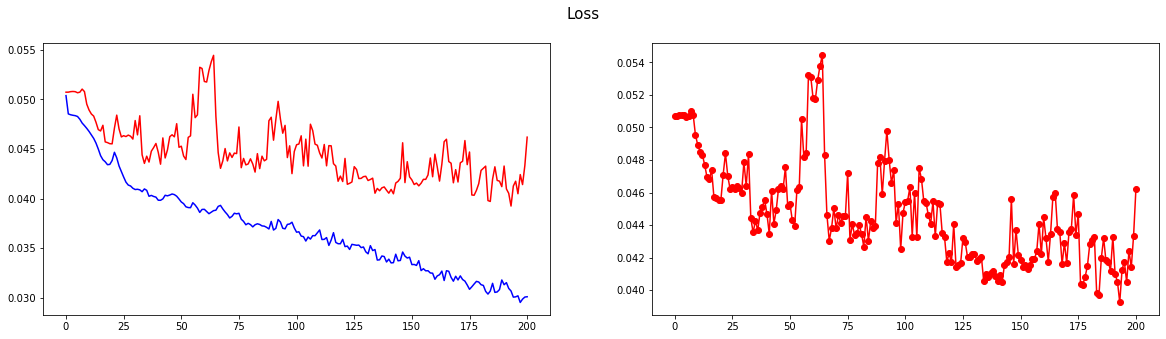

In [14]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

ax0 = ax[0]
ax0.plot(train_loss_list, c= 'blue')
ax0.plot(valid_loss_list, c='red')

ax1 = ax[1]
ax1.plot(valid_loss_list, c='red', marker='o')

fig.suptitle("Loss", fontsize=15)
plt.savefig(result_folder+'drcnn_loss.png')

In [15]:
pd.DataFrame([train_loss_list, valid_loss_list]).to_csv(result_folder + 'drcnn_loss.csv', index=0)

### Performance Evaluation

In [16]:
checkpoint = torch.load(result_folder + 'cnn-swcapsule-pred-traffic-best.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
criterion = checkpoint['criterion']
print(checkpoint['epoch'], checkpoint['loss'])

193 0.03924190100621094


In [17]:
model = model.eval()
test_loss = []
answers = []
predictions = []

X_test = data.test[0]
Y_test = data.test[1]

with torch.no_grad():
    for (x, y) in tqdm(data.get_batches(X_test, Y_test, 64, False), leave=False):
        x = x.to(device)
        y = y.to(device)

        outputs = model(x).squeez()
        y = y.squeeze()

        scale = data.scale.expand(outputs.size(0), horizon, data.m).squeeze()
        bias = data.bias.expand(outputs.size(0), horizon, data.m).squeeze()

        loss = torch.sqrt(criterion(outputs*scale+bias, y*scale+bias))
        
        answers.extend((y*scale+bias).squeeze().detach().cpu().numpy())
        predictions.extend((outputs*scale+bias).squeeze().detach().cpu().numpy())
        test_loss.append(loss.item())  
        
test_loss = np.mean(test_loss)
print(f'test loss: {test_loss}')

0it [00:00, ?it/s]

test loss: 0.04474461193789135


In [18]:
result_ans = pd.DataFrame(answers)
result_pred = pd.DataFrame(predictions)

result_ans.to_csv(result_folder + 'result_ans.csv')
result_pred.to_csv(result_folder + 'result_pred.csv')

In [19]:
result_ans.shape

(3509, 862)

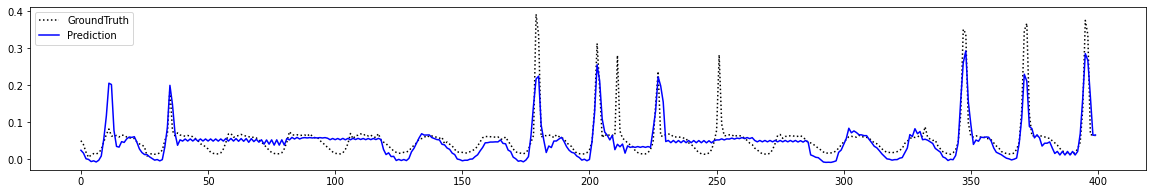

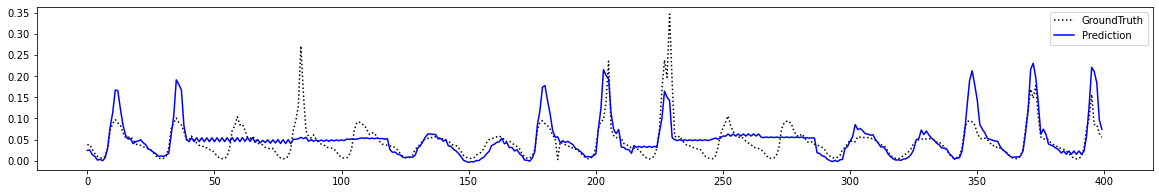

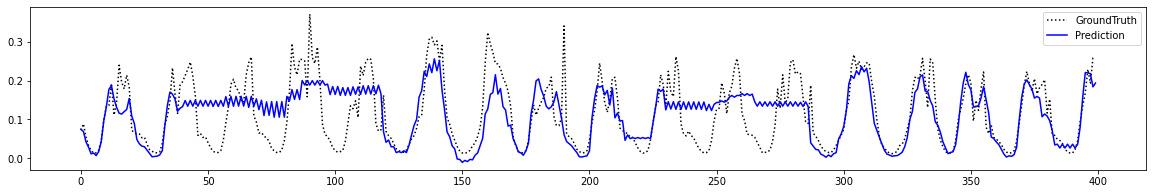

In [27]:
for i in range(3):
    plt.figure(figsize=(20,3))
    plt.plot(result_ans.iloc[:400, i], c='black', ls=':', label = 'GroundTruth')
    plt.plot(result_pred.iloc[:400, i], c='blue', label='Prediction')
    plt.legend()
    plt.savefig(result_folder + f'sample{i}_predresult.png')

## Manual Attack

In [21]:
def attack_inference(model, test_loader, attack):
    data = loader
    model = model.eval()
    X_test, Y_test = test_loader
    
    test_loss = []
    predictions = []
    answers = []
    with torch.no_grad():
        for (x, y) in tqdm(data.get_batches(X_test, Y_test, 64, False), leave=False):
            x = x.to(device)
            y = y.to(device)

            outputs = model(x).squeeze()
            y = y.squeeze()

            scale = data.scale.expand(outputs.size(0), horizon, data.m).squeeze()
            bias = data.bias.expand(outputs.size(0), horizon, data.m).squeeze()

            loss = criterion(outputs*scale+bias, y*scale+bias)

            answers.extend((y*scale+bias).squeeze().detach().cpu().numpy())
            predictions.extend((outputs*scale+bias).squeeze().detach().cpu().numpy())
            test_loss.append(loss.item())  

    test_loss = np.mean(test_loss)
    return answers, predictions

In [22]:
def np_mse(A, B):
    return (np.square(A - B)).mean()

0it [00:00, ?it/s]

offset 0.051358897


0it [00:00, ?it/s]

increase 0.051297583


0it [00:00, ?it/s]

decrease 0.051297847


0it [00:00, ?it/s]

backward 0.051318094


0it [00:00, ?it/s]

forward 0.05131424


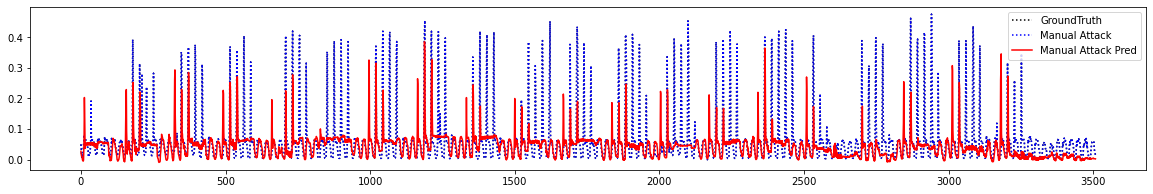

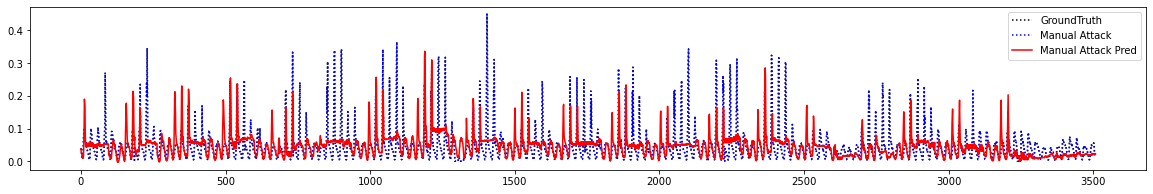

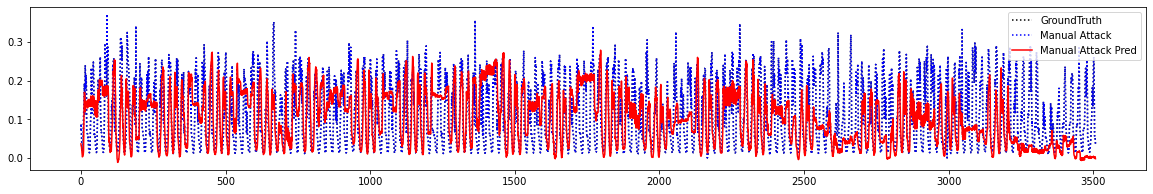

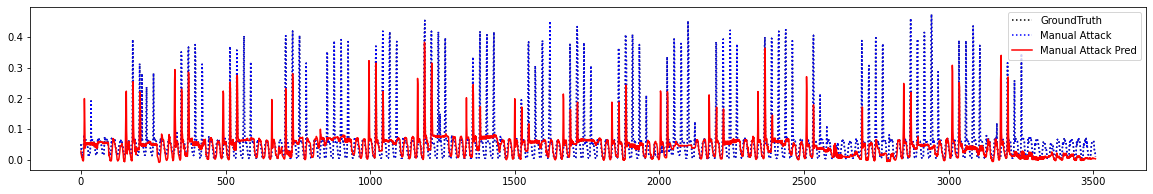

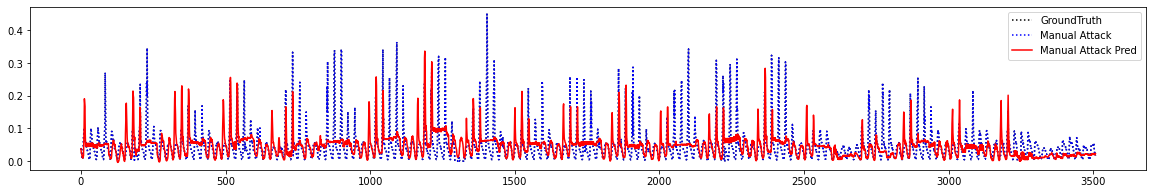

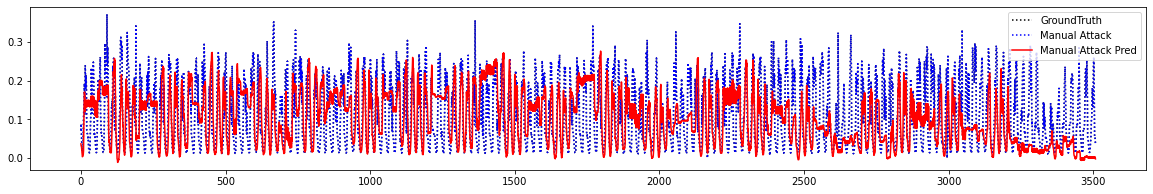

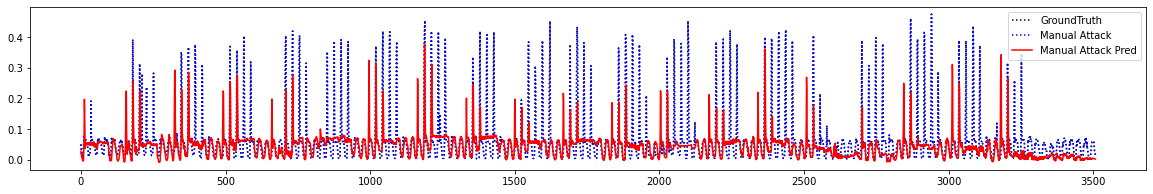

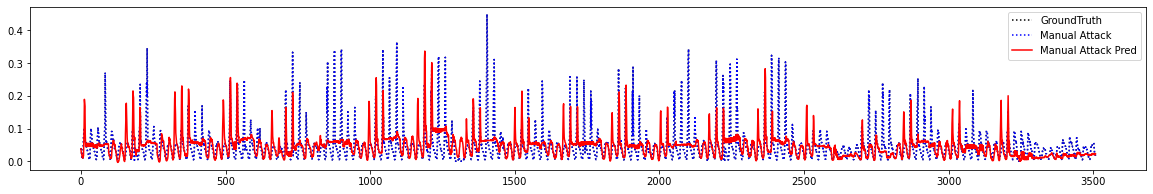

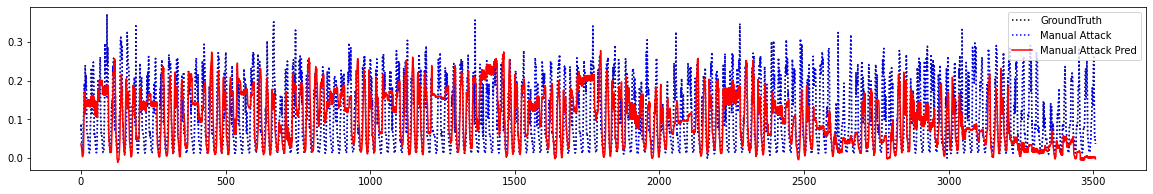

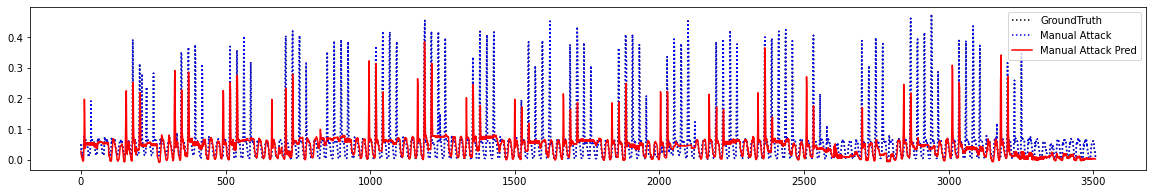

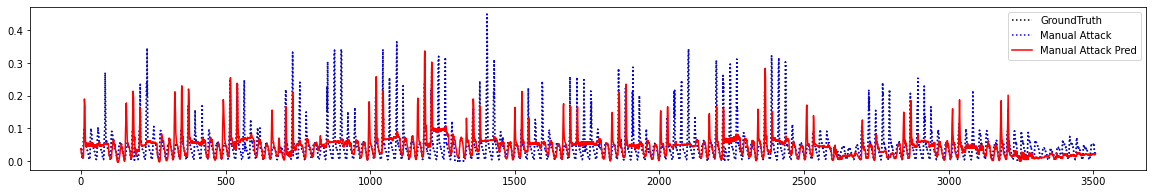

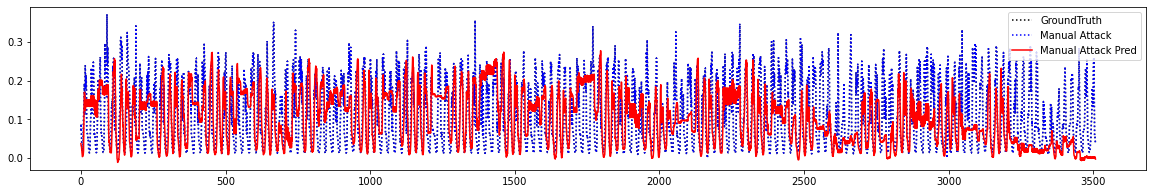

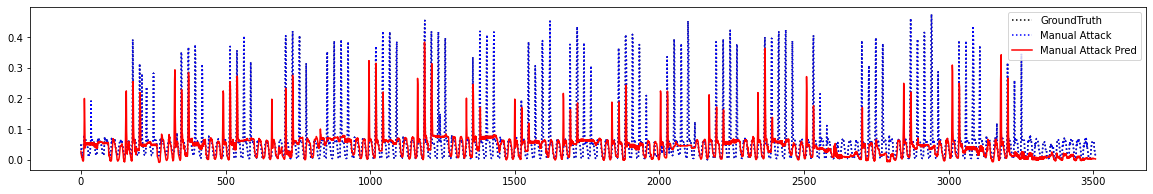

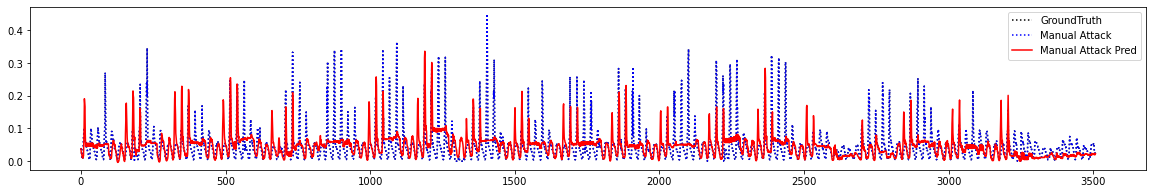

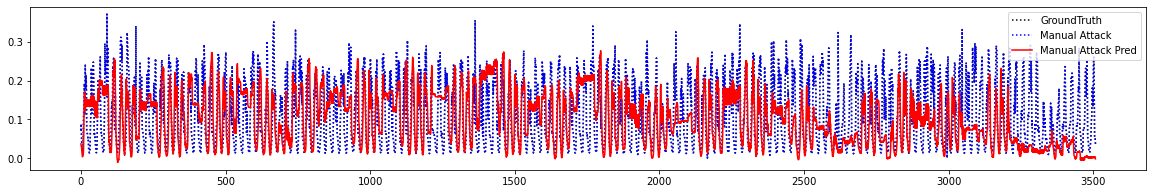

In [23]:
import pickle 
data = loader
X_test = data.test[0].to(device)
Y_test = data.test[1].to(device)
for attack in ['offset', 'increase', 'decrease', 'backward', 'forward']:
    with open(data_folder+f'traffic_{attack}Attack.pkl', 'rb') as f:
        data_ = pickle.load(f)
    X_test_attack = data_['data'].to(device)
    
    attack_loader = [X_test_attack, Y_test]
        
    answers, predictions = attack_inference(model,attack_loader, attack)
    print(attack, np.sqrt(np_mse(result_ans.values, predictions)))
    result_ans_attack = pd.DataFrame(answers)
    result_ans_attack.to_csv(result_folder + f'cnndr_{attack}_prediction.csv')
    result_pred_attack = pd.DataFrame(predictions)
    result_pred_attack.to_csv(attack_result_folder + f'cnndr_{attack}_prediction_pred.csv')
    
    for i in range(3):
        plt.figure(figsize=(20,3))
        plt.plot(result_ans.iloc[:, i], c='black', ls=':', label = 'GroundTruth')
        plt.plot(result_ans_attack.iloc[:, i], c='blue', ls=':', label='Manual Attack')
        plt.plot(result_pred_attack.iloc[:, i], c='red', label='Manual Attack Pred')
        plt.legend()
        plt.savefig(result_folder + f'{attack}_sample{i}_predresult.png')

## Black Box Attack - fgsm ##

In [24]:
def fgsm_attack(model, criterion, x, y, eps, device) :
    x = x.to(device)
    y = y.to(device)
    x.requires_grad = True
    
    outputs = model(x).squeeze()
    y = y.squeeze()
    
    model.zero_grad()
    
    scale = data.scale.expand(outputs.size(0), horizon, data.m).squeeze()
    bias = data.bias.expand(outputs.size(0), horizon, data.m).squeeze()
        
    cost = criterion(outputs*scale+bias, (y*scale+bias).squeeze()).to(device)
    cost.backward()
    
    attack_x = x + eps * x.grad.sign()    
    return attack_x

In [25]:
fgsm_x = []
for (x, y) in tqdm(data.get_batches(X_test, Y_test, 64, False), leave=False):
    attack_x = fgsm_attack(model, criterion, x, y, 0.1, device)
    fgsm_x.append(attack_x)
fgsm_x = torch.cat(fgsm_x, dim=0)
fgsm_test_loader = [fgsm_x, Y_test]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

fgsm 0.12135723


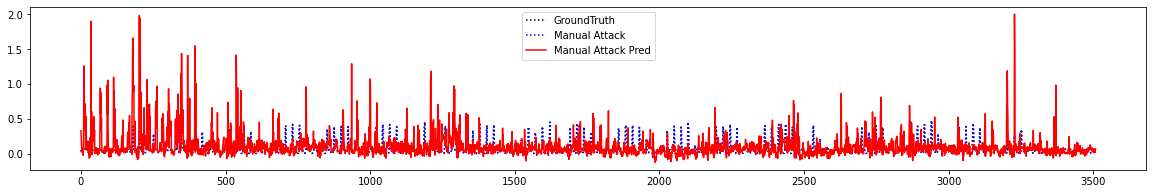

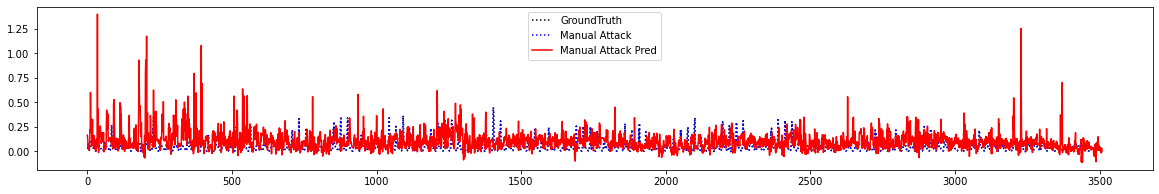

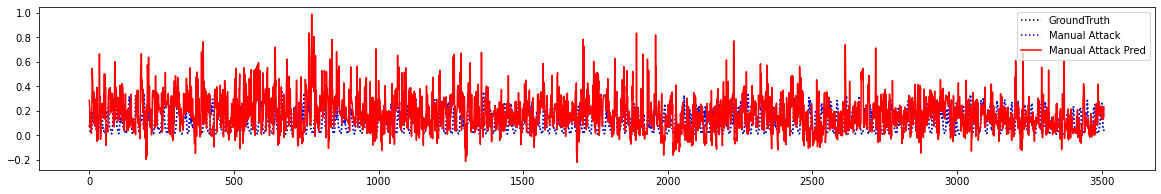

In [26]:
attack = 'fgsm'
answers, predictions = attack_inference(model,fgsm_test_loader, attack)
print(attack, np.sqrt(np_mse(result_ans.values, predictions)))
result_ans_attack = pd.DataFrame(answers)
result_ans_attack.to_csv(result_folder + f'cnndr_{attack}_prediction.csv')
result_pred_attack = pd.DataFrame(predictions)
result_pred_attack.to_csv(attack_result_folder + f'cnndr_{attack}_prediction_pred.csv')
    
for i in range(3):
    plt.figure(figsize=(20,3))
    plt.plot(result_ans.iloc[:, i], c='black', ls=':', label = 'GroundTruth')
    plt.plot(result_ans_attack.iloc[:, i], c='blue', ls=':', label='Manual Attack')
    plt.plot(result_pred_attack.iloc[:, i], c='red', label='Manual Attack Pred')
    plt.legend()
    plt.savefig(result_folder + f'{attack}_sample{i}_predresult.png')